In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import pycomlink as pycml

import pycomlink.processing.wet_dry.mlp as mlp

# Load and preprocess example data 

These steps are similar to the steps performed in the notebook "Basic CML processing workflow.ipynb". 

In [4]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# Estimate rainy periods and determine baseline

In this notebook, we will compare three different methods of estimating rainfall periods in the CML time series:
1. The first method uses a Rolling Standard Deviation approach ([Schleiss et al. 2010](https://ieeexplore.ieee.org/document/5438724)).
2. The second method employs a Multilayer Perceptron (MLP), which is trained on high-resolution weather radar data ([Øydvin et al. 2024](https://egusphere.copernicus.org/preprints/2024/egusphere-2024-647)).
7. The third method improves upon the second by detrending the signal attenuation using the first-order derivative, enabling real-time rainfall classification. Note that this approach has not yet been published or undergone extensive testing.

Please note that the Convolutional Neural Network (CNN) previously featured in this notebook has been removed due to the removal of TensorFlow from pycomlink. However, it can still be installed from these repositories:
- [cml_wd_pytorch](https://github.com/jpolz/cml_wd_pytorch)
- [cnn_cml_wet-dry_example](https://github.com/jpolz/cnn_cml_wet-dry_example?tab=readme-ov-file)

In [5]:
# 1. wet dry detection using rsd
cmls['wet_rsd'] = cmls.tl.rolling(time=60, center=True).std() > 0.8

# 2. wet dry detection using MLP rain gauge model
cmls['wet_mlp_rad'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).tl,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).tl,
        model_sel = 'rad' # model based on rain gauge training data
    )
    cmls['wet_mlp_rad'].loc[{'cml_id':cml_id}]=  np.argmax(mlp_out, axis = 1)

# 3. wet dry detection using MLP rain gauge online model
cmls['wet_mlp_rad_online'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).tl,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).tl,
        model_sel = 'rad_online' # model based on radar training data, online capabilities
    )
    cmls['wet_mlp_rad_online'].loc[{'cml_id':cml_id}]=  np.argmax(mlp_out, axis = 1)

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.72it/s]


Determine baseline using one of these two approaches:
1. Using the dry time steps before rainy periods.
2. Using the 5 hour rolling median of dry timesteps.

In [6]:
# Determine baseline for the RSD method using the previous dry timesteps
cmls['baseline_rsd'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_rsd, n_average_last_dry=5)

# Determine baseline for the MLP rad method using the rolling median 
cmls['tl_nan'] = xr.where(cmls.wet_mlp_rad, np.nan, cmls.tl)
cmls['baseline_mlp_rad'] = xr.where(
    cmls.wet_mlp_rad, 
    cmls.tl_nan.rolling(time = 60*5, min_periods = 60).median(), # 5 hours
    cmls.tl
)

# Determine baseline for the MLP rad online method using the rolling median 
cmls['tl_nan'] = xr.where(cmls.wet_mlp_rad_online, np.nan, cmls.tl)
cmls['baseline_mlp_rad_online'] = xr.where(
    cmls.wet_mlp_rad_online, 
    cmls.tl_nan.rolling(time = 60*5, min_periods = 60).median(), # 5 hours
    cmls.tl
)

# Plot TL and baseline for CML

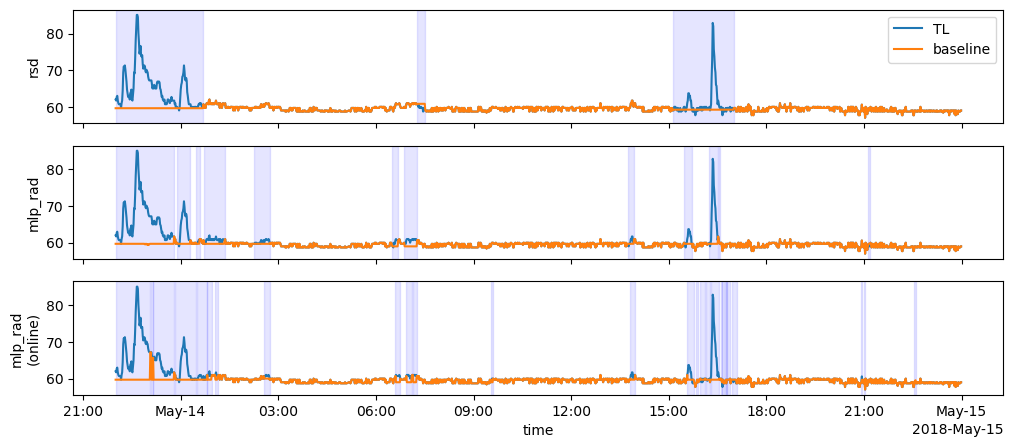

In [7]:
start = '2018-05-13T22'
end = '2018-05-14'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 0, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)
cml_plot['wet_mlp_rad'] = cml_plot.fillna(0).wet_mlp_rad.astype(bool)
cml_plot['wet_mlp_rad_online'] = cml_plot.fillna(0).wet_mlp_rad_online.astype(bool)

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs[0], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[1], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[2], label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp_rad
cml_plot['wet_mlp_rad'][0] = 0 
cml_plot['wet_mlp_rad'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rad, -1) & ~cml_plot.wet_mlp_rad
wet_end = np.roll(cml_plot.wet_mlp_rad, 1) & ~cml_plot.wet_mlp_rad
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp rad online
cml_plot['wet_mlp_rad_online'][0] = 0 
cml_plot['wet_mlp_rad_online'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rad_online, -1) & ~cml_plot.wet_mlp_rad_online
wet_end = np.roll(cml_plot.wet_mlp_rad_online, 1) & ~cml_plot.wet_mlp_rad_online
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)



cml_plot.baseline_rsd.plot.line(x='time', ax=axs[0], label ='baseline');
cml_plot.baseline_mlp_rad.plot.line(x='time', ax=axs[1], label ='baseline');
cml_plot.baseline_mlp_rad_online.plot.line(x='time', ax=axs[2], label ='baseline');

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');

axs[0].set_ylabel('rsd')
axs[1].set_ylabel('mlp_rad')
axs[2].set_ylabel('mlp_rad\n(online)')

axs[0].legend(loc = 'upper right')

# Plot TL and baseline for another CML

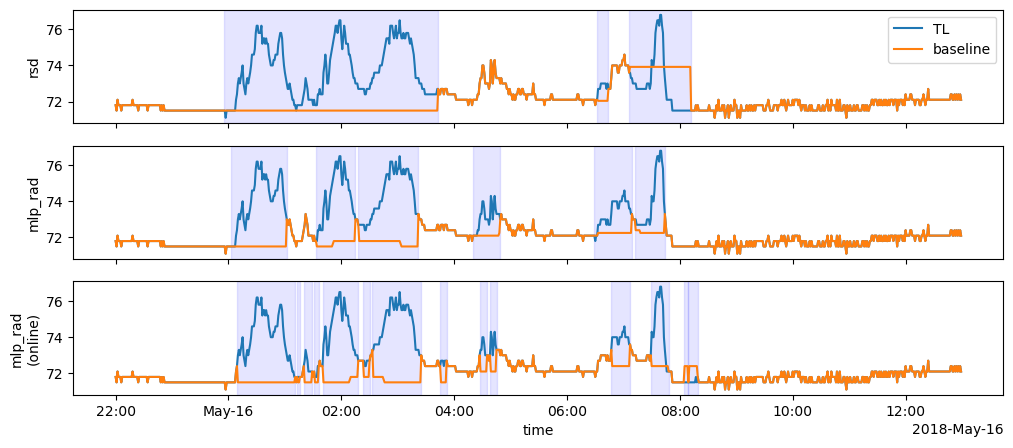

In [8]:
start = '2018-05-15T22'
end = '2018-05-16T12'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 2, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)
cml_plot['wet_mlp_rad'] = cml_plot.fillna(0).wet_mlp_rad.astype(bool)
cml_plot['wet_mlp_rad_online'] = cml_plot.fillna(0).wet_mlp_rad_online.astype(bool)

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs[0], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[1], label = 'TL');
cml_plot.tl.plot.line(x='time', ax=axs[2], label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp_rad
cml_plot['wet_mlp_rad'][0] = 0 
cml_plot['wet_mlp_rad'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rad, -1) & ~cml_plot.wet_mlp_rad
wet_end = np.roll(cml_plot.wet_mlp_rad, 1) & ~cml_plot.wet_mlp_rad
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

# shaded mlp rad online
cml_plot['wet_mlp_rad_online'][0] = 0 
cml_plot['wet_mlp_rad_online'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp_rad_online, -1) & ~cml_plot.wet_mlp_rad_online
wet_end = np.roll(cml_plot.wet_mlp_rad_online, 1) & ~cml_plot.wet_mlp_rad_online
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)



cml_plot.baseline_rsd.plot.line(x='time', ax=axs[0], label ='baseline');
cml_plot.baseline_mlp_rad.plot.line(x='time', ax=axs[1], label ='baseline');
cml_plot.baseline_mlp_rad_online.plot.line(x='time', ax=axs[2], label ='baseline');

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');

axs[0].set_ylabel('rsd')
axs[1].set_ylabel('mlp_rad')
axs[2].set_ylabel('mlp_rad\n(online)')

axs[0].legend(loc = 'upper right')